In [82]:
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pyplot as plt
import torch.nn
from sklearn.preprocessing import MinMaxScaler

In [83]:
df = yf.download('NVDA', start='2024-01-01', end='2024-12-01')

[*********************100%***********************]  1 of 1 completed


In [84]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2024-01-02,48.154346,48.167999,49.294998,47.595001,49.243999,411254000
2024-01-03,47.555515,47.569000,48.183998,47.320000,47.485001,320896000
2024-01-04,47.984398,47.998001,48.500000,47.507999,47.766998,306535000
2024-01-05,49.083080,49.097000,49.547001,48.306000,48.462002,415039000
2024-01-08,52.238186,52.252998,52.275002,49.479000,49.512001,642510000
...,...,...,...,...,...,...
2024-11-22,141.940216,141.949997,147.160004,141.100006,145.929993,236406200
2024-11-25,136.010635,136.020004,142.050003,135.820007,141.990005,344941900


In [85]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # First LSTM layer with Dropout
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(p=0.2)
        
        # Second LSTM layer with Dropout
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.dropout2 = nn.Dropout(p=0.3)
        
        # Third LSTM layer with Dropout
        self.lstm3 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.dropout3 = nn.Dropout(p=0.4)
        
        # Fourth LSTM layer with Dropout
        self.lstm4 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True)
        self.dropout4 = nn.Dropout(p=0.5)
        
        # Fully connected output layer
        self.fc = nn.Linear(in_features=256, out_features=1)

    def forward(self, x):
        # Pass through first LSTM layer and apply dropout
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        # Pass through second LSTM layer and apply dropout
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        # Pass through third LSTM layer and apply dropout
        x, _ = self.lstm3(x)
        x = self.dropout3(x)
        
        # Pass through fourth LSTM layer and apply dropout
        x, _ = self.lstm4(x)
        x = self.dropout4(x)
        
        # Take the output of the last time step and pass it through the fully connected layer
        x = self.fc(x[:, -1, :])

        return x

In [86]:
model = Model()
print(model)

Model(
  (lstm1): LSTM(5, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (lstm3): LSTM(128, 256, batch_first=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (lstm4): LSTM(256, 256, batch_first=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [87]:
scalers = {
    'Adj Close': MinMaxScaler(),
    'Close': MinMaxScaler(),
    'Low': MinMaxScaler(),
    'High': MinMaxScaler(),
    'Open': MinMaxScaler(),
    'Volume' : MinMaxScaler()
}

df['Adj Close'] = scalers['Adj Close'].fit_transform(df[['Adj Close']])
df['Close'] = scalers['Close'].fit_transform(df[['Close']])
df['Low'] = scalers['Low'].fit_transform(df[['Low']])
df['High'] = scalers['High'].fit_transform(df[['High']])
df['Open'] = scalers['Open'].fit_transform(df[['Open']])
df['Volume'] = scalers['Volume'].fit_transform(df[['Volume']])

In [88]:
df = df.drop(columns=['Adj Close'])

In [89]:
df_data = df.values

In [90]:


# Convert data into sequences
def create_sequences(data_array, sequence_length):
    X = []
    y = []
    for i in range(len(data_array) - sequence_length):
        # Extract sequence of features
        X.append(data_array[i:i + sequence_length])
        # Target is the closing price at the next timestep
        y.append(data_array[i + sequence_length][0])  
    return np.array(X), np.array(y)

sequence_length = 5

X_sequences, y_targets = create_sequences(df_data, sequence_length)

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_targets, train_size=0.8, shuffle=False)

In [92]:
X_sequences.shape, y_targets.shape
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.float32)
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.float32)

In [93]:
from torch.utils.data import DataLoader, TensorDataset
dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [94]:
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [95]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    
    for X_batch, y_batch in dataloader_train:
        optimizer.zero_grad()  # Clear gradients from the previous step
        
        y_pred = model(X_batch)  # Forward pass
        
        loss = criterion(y_pred.squeeze(), y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        
        optimizer.step()  # Update weights
        
        epoch_loss += loss.item() * X_batch.size(0)  # Accumulate loss
    
    epoch_loss /= len(dataloader_train.dataset)  # Average loss over all samples
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/50, Loss: 0.5321
Epoch 2/50, Loss: 0.1809
Epoch 3/50, Loss: 0.0796
Epoch 4/50, Loss: 0.0533
Epoch 5/50, Loss: 0.0467
Epoch 6/50, Loss: 0.0230
Epoch 7/50, Loss: 0.0278
Epoch 8/50, Loss: 0.0222
Epoch 9/50, Loss: 0.0128
Epoch 10/50, Loss: 0.0096
Epoch 11/50, Loss: 0.0091
Epoch 12/50, Loss: 0.0095
Epoch 13/50, Loss: 0.0074
Epoch 14/50, Loss: 0.0075
Epoch 15/50, Loss: 0.0078
Epoch 16/50, Loss: 0.0062
Epoch 17/50, Loss: 0.0069
Epoch 18/50, Loss: 0.0065
Epoch 19/50, Loss: 0.0066
Epoch 20/50, Loss: 0.0086
Epoch 21/50, Loss: 0.0056
Epoch 22/50, Loss: 0.0061
Epoch 23/50, Loss: 0.0083
Epoch 24/50, Loss: 0.0059
Epoch 25/50, Loss: 0.0058
Epoch 26/50, Loss: 0.0065
Epoch 27/50, Loss: 0.0058
Epoch 28/50, Loss: 0.0059
Epoch 29/50, Loss: 0.0050
Epoch 30/50, Loss: 0.0060
Epoch 31/50, Loss: 0.0052
Epoch 32/50, Loss: 0.0066
Epoch 33/50, Loss: 0.0055
Epoch 34/50, Loss: 0.0070
Epoch 35/50, Loss: 0.0048
Epoch 36/50, Loss: 0.0052
Epoch 37/50, Loss: 0.0066
Epoch 38/50, Loss: 0.0062
Epoch 39/50, Loss: 0.

In [96]:
dataset_test = TensorDataset(X_tensor_test, y_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()  # Set model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in dataloader_test:
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        test_loss += loss.item() * X_batch.size(0)

In [97]:
test_loss /= len(dataloader_test.dataset)  # Average test loss

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0022


In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions on test set
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in dataloader_test:
        y_pred_list.append(model(X_batch).squeeze().numpy())
        y_true_list.append(y_batch.numpy())

y_pred_list = np.concatenate(y_pred_list)
y_true_list = np.concatenate(y_true_list)

mse = mean_squared_error(y_true_list, y_pred_list)
mae = mean_absolute_error(y_true_list, y_pred_list)

print(f"Test MSE: {mse:.4f}, Test MAE: {mae:.4f}")


Test MSE: 0.0022, Test MAE: 0.0374


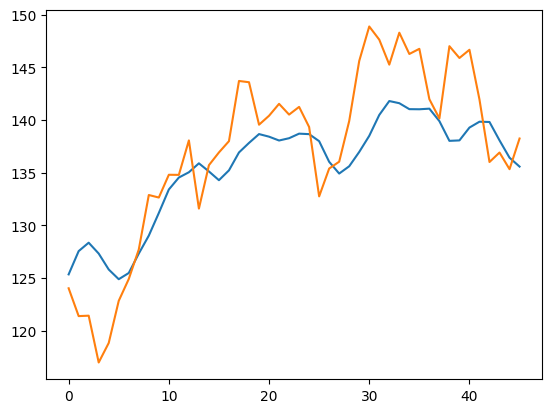

In [99]:
plt.plot(scalers['Close'].inverse_transform(y_pred_list[:].reshape(-1,1)))
plt.plot(scalers['Close'].inverse_transform(y_true_list[:].reshape(-1,1)))

In [101]:
residuals = scalers['Close'].inverse_transform(y_true_list[:].reshape(-1,1)) - scalers['Close'].inverse_transform(y_pred_list[:].reshape(-1,1))

In [103]:
def forecast_future(model, last_sequence, num_predictions, scaler):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(num_predictions):
        model.eval()
        next_value = model(torch.tensor(current_sequence, dtype=torch.float32)).detach().numpy()
        
        # Inverse transform to get original scale
        next_value_original = scalers["Close"].inverse_transform(next_value[0].reshape(-1,1))
        predictions.append(next_value_original[0][0])  # Assuming single output
        
        # Update the sequence: remove oldest value, append predicted value
        next_value_scaled = scalers["Close"].transform(next_value)  # Scale predicted value
        current_sequence = np.append(current_sequence[:, -1, :], [[next_value_scaled]], axis=1)

    return predictions

In [104]:
# Start with the last sequence in the dataset
current_input = X_tensor_test[-1].unsqueeze(0)  # Shape: (1, timesteps, features)

# To store predictions
future_predictions = []

model.eval()
with torch.no_grad():
    for _ in range(5):
        # Predict the next value
        next_pred = model(current_input)  # Shape: (1, 1)

        # Store the prediction
        future_predictions.append(next_pred.item())

        # Update the input sequence
        next_input = current_input[:, 1:, :]  # Remove the first timestep (shift the window)
        next_input = torch.cat((next_input, torch.zeros(1, 1, current_input.size(2))), dim=1)  # Add placeholder for the new timestep

        # Insert the predicted value into the second column (target feature)
        next_input[:, -1, 1] = next_pred.squeeze(1)  # Replace column index 1 with prediction

        current_input = next_input

# Convert predictions to a tensor
future_predictions = torch.tensor(future_predictions)
print("Future Predictions:", future_predictions)

Future Predictions: tensor([0.8688, 0.7160, 0.4899, 0.3585, 0.2804])


In [108]:
final_forecast = scalers['Close'].inverse_transform(y_pred_list.reshape(-1,1)) + forecast.reshape(-1)

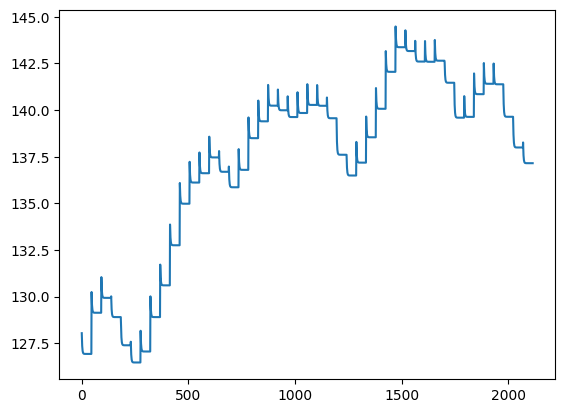

In [109]:
plt.plot(final_forecast.reshape(-1,1))

In [110]:
final_forecast[0]

array([128.03786966, 127.61277186, 127.35019361, 127.1880019 ,
       127.08781787, 127.02593529, 126.9877111 , 126.96410044,
       126.94951639, 126.94050798, 126.93494359, 126.93150652,
       126.92938349, 126.92807211, 126.92726209, 126.92676175,
       126.92645269, 126.92626179, 126.92614387, 126.92607104,
       126.92602605, 126.92599826, 126.92598109, 126.92597049,
       126.92596394, 126.92595989, 126.92595739, 126.92595585,
       126.9259549 , 126.92595431, 126.92595394, 126.92595372,
       126.92595358, 126.92595349, 126.92595344, 126.92595341,
       126.92595339, 126.92595338, 126.92595337, 126.92595336,
       126.92595336, 126.92595336, 126.92595336, 126.92595336,
       126.92595336, 126.92595336])

In [178]:
torch.save(model.state_dict(), "Desktop/lstm_model.pth")

In [179]:
model = Model()
model.load_state_dict(torch.load("lstm_model.pth"))
model.eval()
outs = model(X_tensor_test[-1].unsqueeze(0) )

/var/folders/zd/dmj5p6xs4_53hhy5fq5j6kkm0000gn/T/ipykernel_54280/1370512238.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lstm_model.

In [181]:
scalers['Close'].inverse_transform(outs.detach().numpy())

array([[135.58617]], dtype=float32)

In [198]:
t = X_tensor_test[-1].unsqueeze(0)
t[:,:,1]

tensor([[1.0000, 0.9453, 0.8965, 0.8702, 0.8503]])

In [183]:
def future_predictions(X):
    current_input = X[-1].unsqueeze(0) 
    future_predictions = []
    
    model.eval()
    with torch.no_grad():
        for _ in range(5):
            # Predict the next value
            next_pred = model(current_input)  # Shape: (1, 1)
    
            # Store the prediction
            future_predictions.append(next_pred.item())
    
            # Update the input sequence
            next_input = current_input[:, 1:, :]  # Remove the first timestep (shift the window)
            next_input = torch.cat((next_input, torch.zeros(1, 1, current_input.size(2))), dim=1)  # Add placeholder for the new timestep
    
            # Insert the predicted value into the second column (target feature)
            next_input[:, -1, 1] = next_pred.squeeze(1)  # Replace column index 1 with prediction
    
            current_input = next_input

    return future_predictions

In [193]:
of = future_predictions(X_tensor_train)

In [200]:
residuals = np.array(of) - t[:,:,1].numpy()

In [194]:
scalers['Close'].inverse_transform(np.array(of).reshape(-1,1))

array([[123.65065885],
       [112.17735492],
       [ 93.6783679 ],
       [ 80.90602083],
       [ 73.076252  ]])